In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
#import pandas as pd
#from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
import keras
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, BatchNormalization, concatenate, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
#from shapely.geometry import MultiPolygon, Polygon
#import shapely.wkt
#import shapely.affinity
#from collections import defaultdict
#import shutil
from tqdm import tqdm

In [ ]:
#TODO: create Fly Generator
class BatchGeneratorFly(object):
    def __init__(self, batch_size = 32, dim_x = 256, dim_y = 256, dim_z = 3, mask_z = [1], shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.mask_z = mask_z
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def generate ()

In [27]:
class BatchGeneratorStatic(object):
    
    def __init__(self, batch_size = 32, dim_x = 256, dim_y = 256, dim_z = 3, mask_z = [1], shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.mask_z = mask_z
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, X, y):
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(X)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_X_temp = [X[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                list_y_temp = [y[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X_out, y_out = self.__data_generation(list_X_temp, list_y_temp)

                yield X_out, y_out

    def __get_exploration_order(self, X):
        
        # Find exploration order
        indexes = np.arange(len(X))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, list_X_temp, list_y_temp):
        # X : (n_samples, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size, self.dim_x, self.dim_y, len(self.mask_z)))

        # Generate data
        for i in range(len(list_X_temp)):
            # Store volume
            img = tiff.imread(list_X_temp[i])
            img = img/1
            img = np.rollaxis(img, 0, 3)
            #print(img.shape)
            X[i, :, :, :] = img

            # Store class
            mask = tiff.imread(list_y_temp[i])
            mask = mask/1
            
            mask = np.rollaxis(mask, 0, 3)
            #print(mask.shape)
            for n, channel in enumerate(self.mask_z):
                y[i, :, :, n] = mask[:, :, channel]
        return X, y
    def debug(self, X, y):
        indexes = self.__get_exploration_order(X)
        imax = int(len(indexes)/self.batch_size)
        
        #for i in range(1):
        # Find list of IDs
        for i in range(1):
            list_X_temp = [X[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
            list_y_temp = [y[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
            # Generate data
            X_out, y_out = self.__data_generation(list_X_temp, list_y_temp)
        print(X_out.shape)
        print(y_out.shape)
BatchGeneratorStatic(mask_z=[0,1,2, 3,4]).debug(X_val, y_val)

(32, 256, 256, 3)
(32, 256, 256, 5)


In [28]:
def jaccard_loss(y_true, y_pred):
    smooth = 0.001
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])

    jac = 1 - (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def iou_metric(y_true, y_pred):
    smooth = 0.001
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(iou)

def jaccard_loss_weighted(y_true, y_pred, weights = 1):
    smooth = 0.001
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])

    jac = 1 - (intersection + smooth) / (sum_ - intersection + smooth)
    jac = jac*weights
    return K.mean(jac)

#def crossentr_jaccard(y_true, y_pred, weights = 1):
   

In [38]:
def split_image(img_path, model, size = (256,256), shear = 0.25):
    # Open tiff and make some changes
    img = tiff.imread(img_path)
    img = np.rollaxis(img, 0, 3)
    h,w,_ = img.shape
    print(img.shape)
    # Create reflective padding
    shear_int = (int(size[0]*shear),int(size[1]*shear))
    pad_h_1 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2
    pad_h_2 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2+(size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))%2
    pad_w_1 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2
    pad_w_2 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2+(size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))%2
    print(pad_h_1,pad_h_2,pad_w_1,pad_w_2)
    img = np.pad(img,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
    
    # Split image into patches
    h,w,_ = img.shape
    img_arr = []
    n_rows = (h-size[0])//(size[0]-shear_int[0])+1
    n_cols = (w-size[1])//(size[1]-shear_int[1])+1
    for i in range(n_rows):
        for j in range(n_cols):
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            img_crop = img[coord_h:coord_h+size[0], coord_w:coord_w+size[1],:]
            img_arr.append(img_crop)
 
    # Create predictions for patches
    mask_arr = []
    for img_crop in img_arr:
        img_to_pred = np.array([img_crop])
        mask_pred = model.predict(img_to_pred)[0]
        mask_arr.append(mask_pred)
    
    # Merge masks in one
    index = 0
    _, _, channels = mask_arr[0].shape
    final_seg = np.zeros((h,w,channels))
    print(final_seg.shape)
    for i in range (n_rows):
        for j in range (n_cols):
            #print(i,j)
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            
            shift_h = shear_int[0]//2
            shift_w = shear_int[1]//2
            
            mask_to_append = mask_arr[index]
            mask_to_append[0:shift_h,:,:]=0
            mask_to_append[size[0]-shift_h:,:,:]=0
            mask_to_append[:,0:shift_w,:]=0
            mask_to_append[:,size[1]-shift_w:,:]=0
                
            final_seg[coord_h:coord_h+size[0], coord_w:coord_w+size[1]]+=mask_to_append
            index+=1
    #print(final_seg.shape)
    print(final_seg.shape)
    final_seg = final_seg[pad_h_1:h-pad_h_2, pad_w_1:w-pad_w_2,:]
    print(final_seg.shape)
    return final_seg

In [18]:
def calculate_statistics(masks_path):
    mask = tiff.imread(masks_path[0])
    num_cls = mask.shape[0]
    statistics = np.zeros(num_cls)
    for mask_path in tqdm(masks_path):
        mask = tiff.imread(mask_path)
        for cls in range (num_cls):
            mask_cls = mask[cls]
            resol = mask_cls.shape[0]*mask_cls.shape[1]
            cls_pixels = np.sum(mask_cls)
            statistics[cls]+=cls_pixels/resol
    statistics /= len(masks_path)
    return statistics

100%|██████████| 18236/18236 [08:45<00:00, 34.67it/s]


array([  3.71031145e-02,   9.47562015e-03,   8.45330304e-03,
         3.05951339e-02,   1.07734789e-01,   2.86959002e-01,
         5.35004305e-03,   1.87519941e-03,   4.40158664e-05,
         1.96648941e-04])

In [ ]:
statistics = calculate_statistics(y_train)
plt.bar(np.arange(10),statistics)
plt.show()

In [24]:
np.sum(statistics)

0.48778686985740005

In [30]:
#loading datasets
X_train = os.listdir('Dataset/DSTL/patches/train/images/')
X_train = ['Dataset/DSTL/patches/train/images/'+name for name in X_train]
y_train = os.listdir('Dataset/DSTL/patches/train/masks/')
y_train = ['Dataset/DSTL/patches/train/masks/'+name for name in y_train]

X_val = os.listdir('Dataset/DSTL/patches/val/images/')
X_val = ['Dataset/DSTL/patches/val/images/'+name for name in X_val]
y_val = os.listdir('Dataset/DSTL/patches/val/masks/')
y_val = ['Dataset/DSTL/patches/val/masks/'+name for name in y_val]

In [31]:
print(X_train[4100])
print(y_train[4100])

Dataset/DSTL/patches/train/images/18754.tif
Dataset/DSTL/patches/train/masks/18754.tif


In [9]:
# Unet v1.0
inputs = Input((256,256,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bn1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis =3 )
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv9)

model = Model(inputs=inputs, outputs=conv10, name = 'Unet')
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ 'accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 32)  896         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 32)  9248        conv2d_1[0][0]                   
___________________________________________________________________________________________

In [32]:
# Unet v1.1 with batchnorms
inputs = Input((256,256,3))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), padding='same')(bn1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv1 = Conv2D(32, (3, 3), padding='same')(act1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
conv2 = Conv2D(64, (3, 3), padding='same')(act2)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
conv3 = Conv2D(128, (3, 3), padding='same')(act3)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
conv4 = Conv2D(256, (3, 3), padding='same')(act4)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
conv5 = Conv2D(512, (3, 3), padding='same')(act5)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)

up6 = concatenate([UpSampling2D(size=(2, 2))(act5), act4], axis=3)
conv6 = Conv2D(256, (3, 3), padding='same')(up6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
conv6 = Conv2D(256, (3, 3), padding='same')(act6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)

up7 = concatenate([UpSampling2D(size=(2, 2))(act6), act3], axis =3 )
conv7 = Conv2D(128, (3, 3), padding='same')(up7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)
conv7 = Conv2D(128, (3, 3), padding='same')(act7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

up8 = concatenate([UpSampling2D(size=(2, 2))(act7), act2], axis=3)
conv8 = Conv2D(64, (3, 3), padding='same')(up8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)
conv8 = Conv2D(64, (3, 3), padding='same')(act8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)

up9 = concatenate([UpSampling2D(size=(2, 2))(act8), act1], axis=3)
conv9 = Conv2D(32, (3, 3), padding='same')(up9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)
conv9 = Conv2D(32, (3, 3), padding='same')(act9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(act9)

model = Model(inputs=inputs, outputs=conv10, name = 'Unet')
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ 'accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 256, 256, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 32)  896         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 256, 256, 32)  128         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [40]:
optimizer = keras.optimizers.SGD(lr=0.003)
model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=['accuracy', iou_metric])
batch_size = 9
training_generator = BatchGeneratorStatic(batch_size = batch_size,mask_z=[0]).generate(X_train, y_train)
validation_generator = BatchGeneratorStatic(batch_size = batch_size, mask_z=[0]).generate(X_val, y_val)

In [41]:
model.fit_generator(generator = training_generator,
                    steps_per_epoch = len(X_train)//batch_size,
                    validation_data = validation_generator,
                    validation_steps = len(X_train)//batch_size, verbose = True,epochs= 1)

Epoch 1/1
2026/2026 [==============================] - 1702s - loss: 0.6099 - acc: 0.9720 - iou_metric: 0.3898 - val_loss: 0.5583 - val_acc: 0.9775 - val_iou_metric: 0.4416


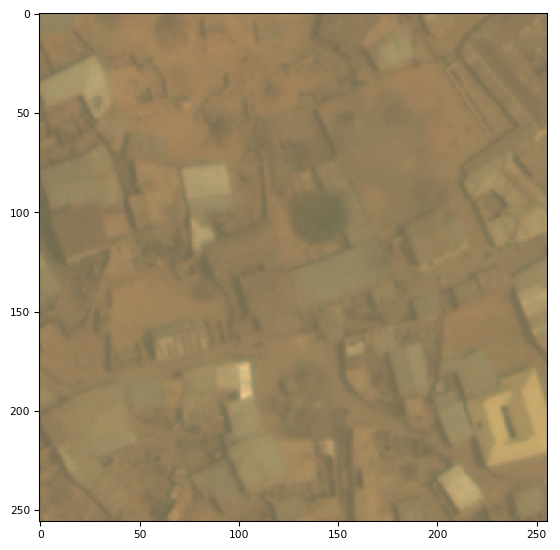

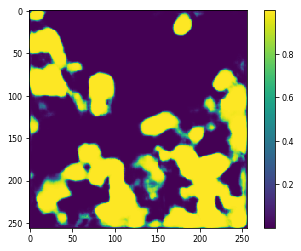

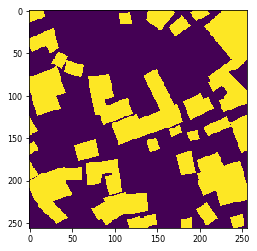

In [42]:
img = tiff.imread(X_val[255])
img = np.rollaxis(img,0,3)
img = np.array([img])
img.shape
truth = tiff.imread(y_val[255])
truth = np.rollaxis(truth,0,3)
prediction = model.predict(img)
tiff.imshow (img[0])
plt.show()
plt.imshow (prediction[0,:,:,0])
plt.colorbar()
plt.show()
plt.imshow (truth[:,:,0])
plt.show()

(3348, 3403, 3)
86 86 58 59
(3520, 3520, 1)
(3520, 3520, 1)
(3348, 3403, 1)


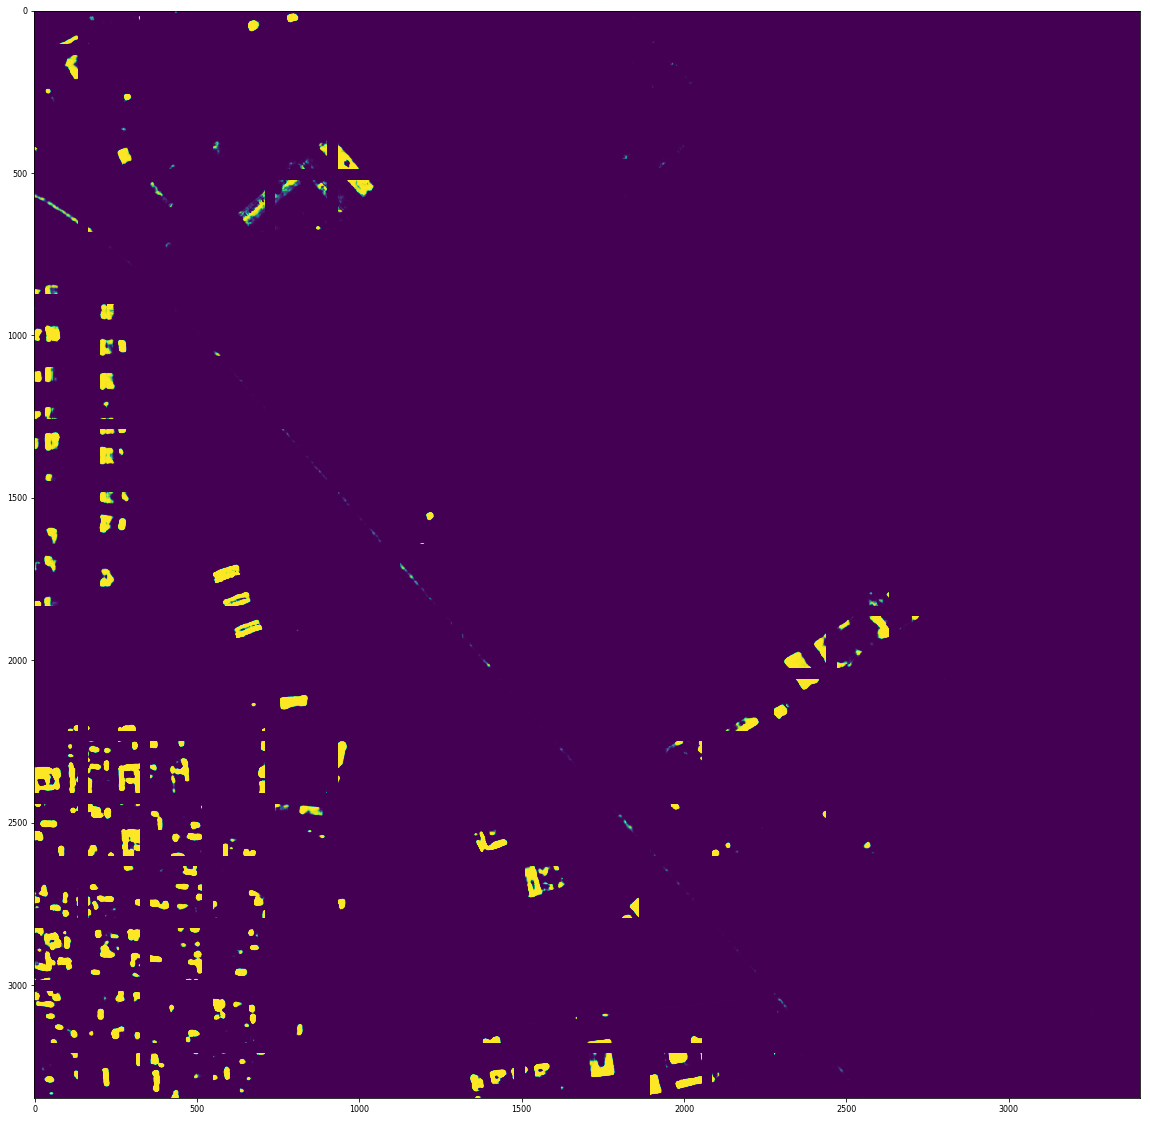

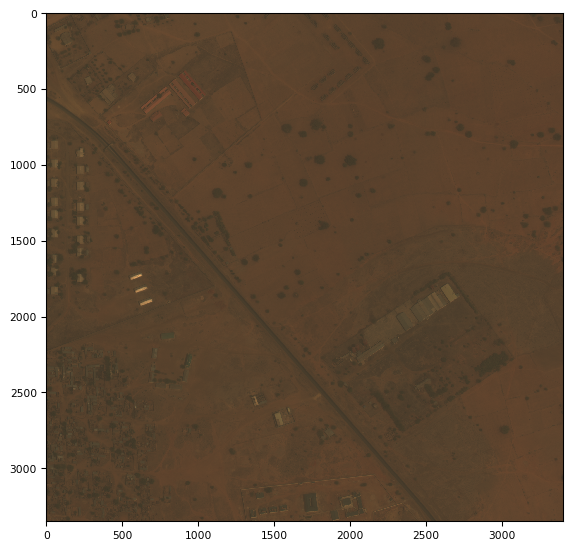

In [43]:
final_seg = split_image('Dataset/DSTL/three_band/6120_3_3.tif',model)
plt.figure(figsize=(20,20))
plt.imshow(final_seg[:,:,0])
plt.show()
img = tiff.imread('Dataset/DSTL/three_band/6120_3_3.tif')
plt.figure(figsize=(20,20))
tiff.imshow(img)
plt.show()

(10, 10, 3)


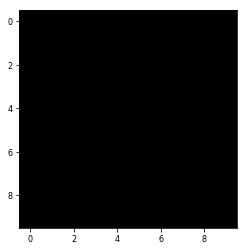

In [73]:
a = np.zeros((10,10,3))
print(a.shape)
plt.imshow(a)
plt.show()